# Solving Stokes equation with $(P_{1}^{CR}, P_{0})$

In [1]:
from skfem import *
import numpy as np
from skfem.visuals.matplotlib import draw, plot
from skfem.utils import solver_iter_krylov, solver_eigen_scipy, solver_iter_pcg
from skfem.helpers import dd, ddot, div, grad
from scipy.sparse.linalg import LinearOperator, minres
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.sparse import bmat
import dmsh
from skfem.assembly import BilinearForm, LinearForm
import scipy.sparse.linalg as spl

## Problem description

$$
\left\{\begin{array}{l}
- \Delta\boldsymbol{u} + \nabla p = \boldsymbol{f} \ in \  \Omega \\
\nabla\cdot\boldsymbol{u} = 0 \ in \  \Omega \\
u = 0 \ on \ \partial \Omega
\end{array}\right.
$$

where 

$$
\left\{\begin{array}{l}
\Delta \mathbf{u}=\sum_{i=1}^{N} \frac{\partial^{2} \mathbf{u}}{\partial x_{i} \partial x_{i}} \\
\nabla p=\left(\frac{\partial p}{\partial x_{1}}, \frac{\partial p}{\partial x_{2}}, \ldots, \frac{\partial p}{\partial x_{N}}\right) \\
\nabla \cdot \mathbf{u}=\sum_{1}^{N} \frac{\partial u_{i}}{\partial x_{i}}
\end{array}\right.
$$

`u` is the velocity vector and `p` is the pressure

Testing case in $\Omega=[0,1] \times [0,1]$:
$$
\left\{\begin{array}{l}
u1 = 10x^{2}(x - 1)^{2}y(y - 1)(2y - 1) \\
u2 = -10y^{2}(y - 1)^{2}x(x - 1)(2x - 1) \\
p = x^{2} - y^{2}
\end{array}\right.
$$

$$
\left(\begin{array}{cc}
A & -B \\
B^{T} & 0
\end{array}\right)\left(\begin{array}{l}
U \\
P
\end{array}\right)=\left(\begin{array}{l}
F_{1} \\
0
\end{array}\right)
$$

## Adding $P_{1}^{CR}$ element

In [2]:
class ElementTriP1CR(ElementH1):
    
    facet_dofs = 1
    dim = 2
    maxdeg = 1
    dofnames = ['u']
    doflocs = np.array([[.5, 0.], [.5, .5], [0., .5]])
    mesh_type = MeshTri

    def lbasis(self, X, i):
        x, y = X

        if i == 0:
            phi = 1. - 2. * y
            dphi = np.array([0. * x, -2. + 0. * y])
            dphi = np.array([0. * x, -2. + 0. * y])
        elif i == 1:
            phi = 2. * x + 2. * y - 1.
            dphi = np.array([2. + 0. * x, 2. + 0. * y])
        elif i == 2:
            phi = 1. - 2. * x
            dphi = np.array([-2. + 0. * x, 0. * x])
        else:
            self._index_error()
        return phi, dphi

## Defining forms

In [57]:
@BilinearForm
def vector_laplace(u, v, w):
    '''
    a
    '''
    return ddot(grad(u), grad(v))


@BilinearForm
def divergence(u, v, w):
    '''
    b
    '''
    return div(u) * v


@LinearForm
def body_force(v, w):
    '''
    for f.*v
    '''
    x, y = w.x
    f1 = 10 * (12 * x**2 - 12 * x + 2) * y * (y - 1) * (2 * y - 1) + 10 * (
        x**2) * ((x - 1)**2) * (12 * y - 6) + 2 * x
    f2 = -(10 * (12 * y**2 - 12 * y + 2) * x * (x - 1) * (2 * x - 1) + 10 *
           (y**2) * ((y - 1)**2) * (12 * x - 6)) - 2 * y
    return f1 * v.value[0] + f2 * v.value[1]


@BilinearForm
def mass(u, v, w):
    '''
    c 
    '''
    return u * v * 0

## Defining exact value and $L_{2}$ error

In [58]:
def exactu(x, y):
    u1 = 10 * (x**2) * ((x - 1)**2) * y * (y - 1) * (2 * y - 1)
    u2 = -10 * (y**2) * ((y - 1)**2) * x * (x - 1) * (2 * x - 1)
    return -u1, -u2


@Functional
def L2Error_u(w):
    x, y = w.x
    u1, u2 = exactu(x, y)
    #     print((w.w[0] - u1)**2)
    #     print((w.w[1] - u2)**2)
    return (w.w[0] - u1)**2 + (w.w[1] - u2)**2


def exactp(x, y):
    return x**2 - y**2


@Functional
def L2Error_p(w):
    x, y = w.x
    return (w.w - exactp(x, y))**2

## Caculating error and convergence rate
> result: $h^{2}$ for `L2u` and $h^{1}$ for `L2p`

### CG (default)

In [59]:
formerL2p = 1
currentL2p = 1
formerL2u = 1
currentL2u = 1
for i in range(5):
    mesh = MeshTri()
    mesh.refine(i)
    element = {'u': ElementVectorH1(ElementTriP1CR()), 'p': ElementTriP0()}
    basis = {
        variable: InteriorBasis(mesh, e, intorder=4)
        for variable, e in element.items()
    }  # intorder: integration order for quadrature

    A = asm(vector_laplace, basis['u'])
    B = asm(divergence, basis['u'], basis['p'])
    C = asm(mass, basis['p'])

    K = bmat([[A, -B.T], [-B, 1e-6 * C]],
             'csr')  # get the sparse format of the result by 'csr'
    f = np.concatenate([asm(body_force, basis['u']), np.zeros(B.shape[0])])

    up = solve(*condense(K, f, D=basis['u'].find_dofs()), solver=solver_iter_krylov(spl.cg))

    uh, ph = np.split(up, [A.shape[0]])
    # p = exactp(basis['p'].doflocs[0], basis['p'].doflocs[1])
    # print((np.sqrt(np.sum((p-ph)**2)))/len(ph))
    P = basis['p'].interpolate(ph).value
    L2p = np.sqrt(L2Error_p.assemble(basis['p'], w=P))
    U = basis['u'].interpolate(uh).value
    L2u = np.sqrt(L2Error_u.assemble(basis['u'], w=U))
    currentL2p = L2p
    currentL2u = L2u
    if i != 0:
        print('2^-' + str(i + 1) + ' case')
        print('L2u Error:', L2u)
        print('L2p Error', L2p)
        print('L2u rate', -np.log2(currentL2u / formerL2u))
        print('L2p rate', -np.log2(currentL2p / formerL2p))
    formerL2p = L2p
    formerL2u = L2u

no M
no M
2^-2 case
L2u Error: 0.04205702226255656
L2p Error 0.25871442184719207
L2u rate 0.18787310551496966
L2p rate 0.7046410684729818
no M
2^-3 case
L2u Error: 0.015225982755278438
L2p Error 0.1361463360074846
L2u rate 1.465811358096462
L2p rate 0.9262023213908652
no M
2^-4 case
L2u Error: 0.0045602098827806775
L2p Error 0.06566564337217475
L2u rate 1.7393632185489305
L2p rate 1.051947509828008
no M
2^-5 case
L2u Error: 0.0012231937630544439
L2p Error 0.03132144722358981
L2u rate 1.8984472700102257
L2p rate 1.0679878672820877


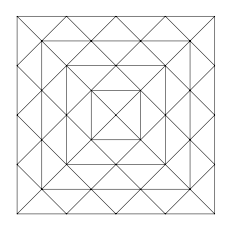

In [71]:
mesh = MeshTri.init_symmetric()
mesh.refine(2)
draw(mesh)

In [60]:
from scipy import sparse
from scipy.sparse import csr_matrix

In [61]:
C.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

## MINRES

In [73]:
formerL2p = 1
currentL2p = 1
formerL2u = 1
currentL2u = 1
for i in range(5):
    # mesh = MeshTri()
    mesh = MeshTri.init_symmetric()
    mesh.refine(i)
    element = {'u': ElementVectorH1(ElementTriP1CR()), 'p': ElementTriP0()}
    basis = {
        variable: InteriorBasis(mesh, e, intorder=4)
        for variable, e in element.items()
    }  # intorder: integration order for quadrature

    A = asm(vector_laplace, basis['u'])
    B = asm(divergence, basis['u'], basis['p'])
    C = asm(mass, basis['p'])

    K = bmat([[A, -B.T], [-B, 1e-6 * C]],
             'csr')  # get the sparse format of the result by 'csr'
    f = np.concatenate([asm(body_force, basis['u']), np.zeros(B.shape[0])])

    up = solve(*condense(K, f, D=basis['u'].find_dofs()), solver=solver_iter_krylov(spl.minres, tol=1e-11, show=False))

    uh, ph = np.split(up, [A.shape[0]])
    # p = exactp(basis['p'].doflocs[0], basis['p'].doflocs[1])
    # print((np.sqrt(np.sum((p-ph)**2)))/len(ph))
    P = basis['p'].interpolate(ph).value
    L2p = np.sqrt(L2Error_p.assemble(basis['p'], w=P))
    U = basis['u'].interpolate(uh).value
    L2u = np.sqrt(L2Error_u.assemble(basis['u'], w=U))
    currentL2p = L2p
    currentL2u = L2u
    if i != 0:
        print('2^-' + str(i + 1) + ' case')
        print('L2u Error:', L2u)
        print('L2p Error', L2p)
        print('L2u rate', -np.log2(currentL2u / formerL2u))
        print('L2p rate', -np.log2(currentL2p / formerL2p))
    formerL2p = L2p
    formerL2u = L2u

no M
no M
2^-2 case
L2u Error: 0.022877238702708122
L2p Error 0.19105843730891744
L2u rate 0.9693896033643069
L2p rate 0.6306275386862156
no M
2^-3 case
L2u Error: 0.0068406344389789
L2p Error 0.08433594487021008
L2u rate 1.7417108883181247
L2p rate 1.1797944105724318
no M
2^-4 case
L2u Error: 0.0019121036322098553
L2p Error 0.039873995166882906
L2u rate 1.8389694183463914
L2p rate 1.080699490985971
no M
2^-5 case
L2u Error: 0.0004969349046194078
L2p Error 0.019221545698984818
L2u rate 1.94403193143341
L2p rate 1.0527238081380013


doesn't converge after swiching to minres